In [1]:
from diffusers import UNet2DModel
from diffusers import DDIMScheduler
from diffusers import SchedulerMixin
import PIL.Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from safetensors.torch import save_file, safe_open
import gc
from aux_functions import *

c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\tesi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
DDIM_pipeline_path = "outputs/output_DDIM_128"  
DDIM_model_path = DDIM_pipeline_path+"/unet"
DDIM_scheduler_path = DDIM_pipeline_path + "/scheduler"
DDPM_pipeline_path = "outputs/output_DDPM_128"  
DDPM_model_path = DDPM_pipeline_path+"/unet"
DDPM_scheduler_path = DDPM_pipeline_path + "/scheduler"
DDIM_inversion_path = "outputs/inversion_DDIM_128"
DDPM_inversion_path = "outputs/inversion_DDPM_128"
if not os.path.exists(DDIM_inversion_path):
    os.makedirs(DDIM_inversion_path)
if not os.path.exists(DDPM_inversion_path):
    os.makedirs(DDPM_inversion_path)

In [3]:
import PIL.IcnsImagePlugin
import PIL.Image
import torch.amp
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

def generatorD(initial_img: torch.Tensor|None, M: UNet2DModel, S: SchedulerMixin, paths: str, num_timesteps: int, seed: int = 0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = paths

    model = M.from_pretrained(model_path)
    model = model.to(device)

    scheduler = S()

    scheduler.set_timesteps(num_timesteps)

    if initial_img == None:
        initial_img = torch.randn(1, 1, 128, 128).to(device)

    image_generated = initial_img.clone().to(device)

    list_of_images = []

    noise_steps = []

    generator = torch.Generator(device='cpu').manual_seed(seed)

    for t in range(num_timesteps):
        predicted_noise = model.forward(image_generated, t).sample
        image_generated = scheduler.step(predicted_noise, t, image_generated, generator=generator).prev_sample
        noise_steps.append(predicted_noise.clone())
        
    list_of_images.clear()        

    return image_generated, noise_steps

def inversion(target: torch.Tensor, S: SchedulerMixin, paths: str, num_timesteps: int, seed: int, save_path: str, initial_noise, start_from = 0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_path = paths

    M = UNet2DModel

    class custom_loss(torch.nn.Module):
        def __init__(self):
            super(custom_loss, self).__init__()

        def forward(self, x_pred, x_true):
            lam =1e-3
            z = torch.randn_like(target)
            return torch.sum(torch.square(x_pred - x_true)) + (lam * torch.sum(torch.square(z)))

    loss_fun = custom_loss()

    if initial_noise is None:
        z = torch.randn(target.size()).to(device).requires_grad_(True)
    elif start_from > 0:
        z = safe_open(DDIM_inversion_path+"/noise_490.safetensors","pt",device=0).get_tensor("z").requires_grad_(True).to(device)
    else:
        print(type(initial_noise))
        z = initial_noise.clone().to(device).requires_grad_(True)

    optimizer = torch.optim.AdamW([z], lr=1e-2) #torch.optim.AdamW()

    #scaler = GradScaler()
    
    print(type(z), z.shape, z.dtype)

    save_image(z, save_path+"/init_noise.png")
    save_image(target, save_path+"/target.png")

    for i in range(num_timesteps):

        optimizer.zero_grad()
        #with autocast():
        x, _ = generatorD(z, M, S, paths, 10, seed)
        #print("Gradiente Salvato?",x.requires_grad)
        loss = loss_fun(x, target)
        
        #print("require grad",z.requires_grad)

        #provare senza scaler
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        loss.backward()
        optimizer.step()

        optimizer.state

        print(f"Step {i+start_from} - Loss: {loss.item()}")
        torch.cuda.empty_cache()
        #save tensor
        if i % 10 == 0:
            st = {
                "z": z,
                "grad": z.grad,
            }
            save_file(st, save_path+f"/noise_{i+start_from}.safetensors")
            os.remove(save_path+f"/noise_{i+start_from-10}.safetensors")
        
    

    save_file(st, save_path+f"/noise_{num_timesteps+start_from}.safetensors")

    torch.cuda.empty_cache()
    gc.collect()

    save_image(z, save_path+"/opt_noise.png")

    ## Visualizza l'immagine iniziale (rumore completo)
    #final_image,_ = generatorD(z, M, S, paths, num_timesteps, seed)
    ##show_image(final_image, title="Inizio del processo di inversione (rumore finale)")
    ##show_image(target, title="Immagine target")
    #save_image(final_image, save_path+"/reconstructed_image.png")
#
    #return final_image

In [19]:
#print(torch.cuda.memory_summary())
torch.cuda.empty_cache()
gc.collect()

#path = "../../datasets/Mayos/test/C081/0.png"
path = "outputs/generated_DDIM_128/2.png"
pil_image = PIL.Image.open(path).convert("L")
#convert image to numpy
np_image = np.array(preprocess(pil_image),dtype=np.float32)
tensor_image = torch.tensor(np_image,requires_grad=True)
tensor_image = tensor_image.unsqueeze(0)
tensor_image = tensor_image.to("cuda")

sched = 'DDIM'
if sched == 'DDIM':
    inversion(tensor_image, DDIMScheduler, DDIM_model_path, 500, 42, DDIM_inversion_path,None,80)
else:
    inversion(tensor_image, DDIMScheduler, DDPM_model_path, 500, 42, DDPM_inversion_path,None)

<class 'torch.Tensor'> torch.Size([1, 1, 128, 128]) torch.float32
Step 80 - Loss: 8864.75390625
Step 81 - Loss: 8732.2607421875
Step 82 - Loss: 8602.185546875
Step 83 - Loss: 8474.2548828125
Step 84 - Loss: 8348.5107421875
Step 85 - Loss: 8225.1923828125
Step 86 - Loss: 8104.22412109375
Step 87 - Loss: 7984.8408203125
Step 88 - Loss: 7866.955078125
Step 89 - Loss: 7750.7587890625
Step 90 - Loss: 7635.5576171875
Step 91 - Loss: 7521.7333984375
Step 92 - Loss: 7408.93505859375
Step 93 - Loss: 7296.3984375
Step 94 - Loss: 7185.0986328125
Step 95 - Loss: 7074.322265625
Step 96 - Loss: 6963.75146484375
Step 97 - Loss: 6854.67578125
Step 98 - Loss: 6745.80419921875
Step 99 - Loss: 6637.44921875
Step 100 - Loss: 6529.4970703125
Step 101 - Loss: 6421.88525390625
Step 102 - Loss: 6315.49951171875
Step 103 - Loss: 6209.3515625
Step 104 - Loss: 6103.72265625
Step 105 - Loss: 5998.21533203125
Step 106 - Loss: 5893.83447265625
Step 107 - Loss: 5790.02880859375
Step 108 - Loss: 5686.89013671875
Step

['grad', 'z']


c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\tesi\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


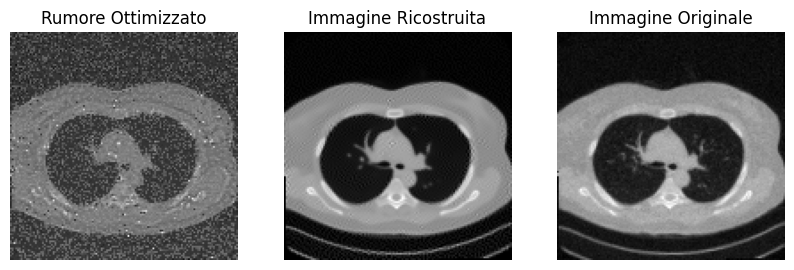

In [4]:
#path = "../../datasets/Mayos/test/C081/0.png"
gc.collect()
torch.cuda.empty_cache()


path = "outputs/generated_DDIM_128/2.png"
pil_image = PIL.Image.open(path).convert("L")
#convert image to numpy
np_image = np.array(preprocess(pil_image),dtype=np.float32)
tensor_image = torch.tensor(np_image,requires_grad=True)
tensor_image = tensor_image.unsqueeze(0)
tensor_image = tensor_image.to("cuda")

saved_tensors = safe_open(DDIM_inversion_path+"/noise_580.safetensors","pt",device='cpu')
print(saved_tensors.keys())
saved_tensor = saved_tensors.get_tensor("z").to("cuda").requires_grad_(True)
#image_generated = inversion(tensor_image, DDIMScheduler, DDIM_model_path, 11, 42, DDIM_inversion_path,saved_tensor,491)
reconstructed = generatorD(saved_tensor, UNet2DModel, DDIMScheduler, DDIM_model_path, 10, 42)[0]


figure = plt.figure(figsize=(10, 10))
cols = 3
rows = 1
figure.add_subplot(rows, cols, 1)
plt.imshow(tensor_to_numpy(saved_tensor), cmap="gray")
plt.title(f"Rumore Ottimizzato")
plt.axis("off")
figure.add_subplot(rows, cols, 2)
plt.imshow(tensor_to_numpy(reconstructed), cmap="gray")
plt.title(f"Immagine Ricostruita")
plt.axis("off")
figure.add_subplot(rows, cols, 3)
plt.imshow(tensor_to_numpy(tensor_image), cmap="gray")
plt.title(f"Immagine Originale")
plt.axis("off")
plt.show()


In [7]:
#measure metrics on the reconstructed image
MSE = torch.nn.functional.mse_loss(reconstructed, tensor_image)
print("MSE:", MSE.item())

print("PSNR: ", 10 * torch.log10(tensor_image.max()**2 / MSE).item())


MSE: 0.0049958378076553345
PSNR:  15.789573192596436
